In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [6]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report


#from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [7]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', '..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'
# log_dir = PATH('')

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 30
ALPHA = 0.1

TEST_SIZE = 0.2
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [8]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [9]:
def fn_plot_tf_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [10]:
###-----------------
### Hyper Parameters
###-----------------
#
# EPOCHS = 200 # number of epochs
# ALPHA = 0.0003 # learning rate
# BATCH_SIZE = 64 # mini batch size (number of rows)
# TEST_SIZE = 0.2 # test size for train-test split
# TRAIN_SIZE=int(18 *BATCH_SIZE)
# WEIGHT_DECAY=0.001 # ADAMW
# PATIENCE=20 # for Early Stopping
# LR_FACTOR =0.1#Reduction on LR Factor
# LR_PATIENCE=3 # how long should i wait
# MIN_LR = 1e-6#min

In [13]:
data_df = pd.read_csv('weatherHistory.csv')
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [17]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [20]:
for feature in data_df.columns:
    print(f"{feature} : {data_df[feature].unique()} \n")

Formatted Date : ['2006-04-01 00:00:00.000 +0200' '2006-04-01 01:00:00.000 +0200'
 '2006-04-01 02:00:00.000 +0200' ... '2016-09-09 21:00:00.000 +0200'
 '2016-09-09 22:00:00.000 +0200' '2016-09-09 23:00:00.000 +0200'] 

Summary : ['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain'] 

Precip Type : ['rain' 'snow' nan] 

Temperature (C) : [ 9.47222222  9.35555556  9.37777778 ... 28.47222222 28.33888889
 30.60555556] 

Apparent Temperature (C) : [ 7.38888889  7.22777778  9.37777778 ... 12.14444444  9.73888889
  9.23333333] 

Humidity : [0.89 0.86 0.83 

In [21]:
data_df['datetime']=pd.to_datetime(data_df['Formatted Date'],utc=True)
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


In [22]:
temp_df=data_df[['datetime','Temperature (C)']]
temp_df=temp_df.sort_values('datetime',axis=0,ascending=True)
temp_df=temp_df.reset_index(drop=True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [25]:
temp_df=temp_df.rename({'Temperature (C)':'temp'},axis=1)

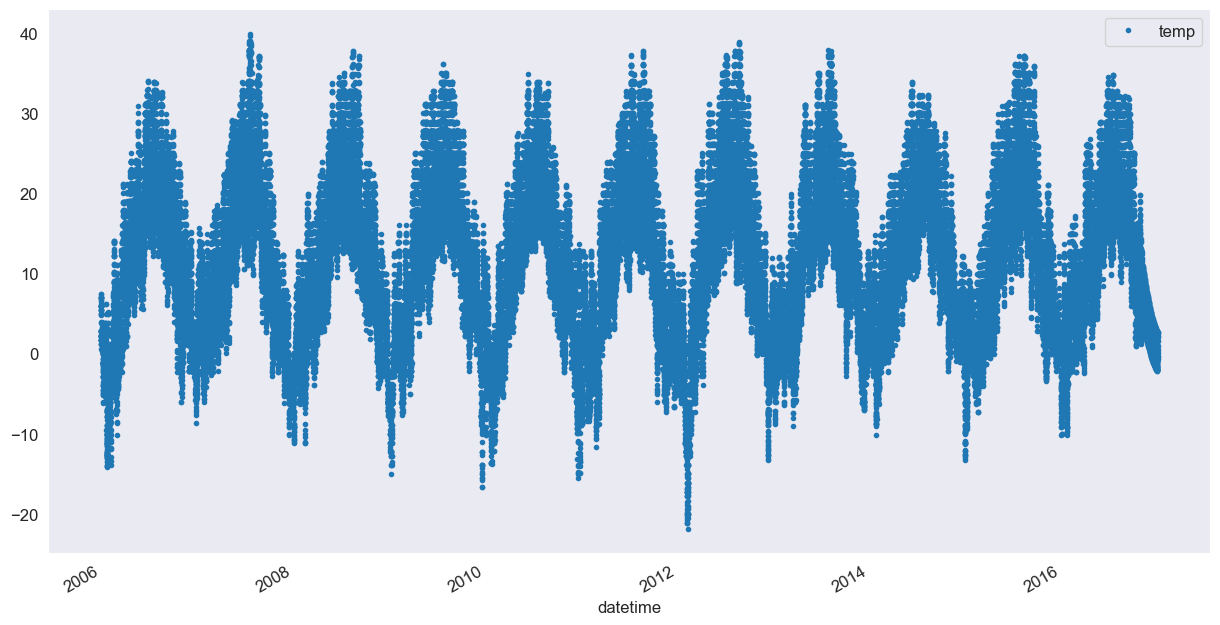

In [26]:
fig,ax=plt.subplots()
temp_df.plot(x='datetime',y='temp',style='.',ax=ax)
ax.grid()

In [27]:
h_units = 100

input_shape = (1,10000)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(tf.keras.layers.SimpleRNN(units=h_units, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='linear'))


In [28]:
wax=model.get_weights()[0].shape
waa=model.get_weights()[1].shape
baa=model.get_weights()[2].shape
way=model.get_weights()[3].shape
wax=model.get_weights()[4].shape
print('Shape of matrix:')
print('Wax=',wax,'Waa=',waa,'Baa=',baa)

Shape of matrix:
Wax= (1,) Waa= (100, 100) Baa= (100,)


In [29]:
time_step=24
y_idx=np.arange(time_step,temp_df.shape[0],time_step)
y_idx

array([   24,    48,    72, ..., 96384, 96408, 96432], shape=(4018,))

In [30]:
y_df=temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [31]:
X_df=temp_df.iloc[range(len(y_df)*time_step)]
X_df.shape

(96432, 2)

In [ ]:
X_df.reshape((len(y_df),))

In [12]:
X_train.shape[0]/BATCH_SIZE

NameError: name 'X_train' is not defined

In [39]:
num_examples = 262 * BATCH_SIZE

X_train = X_train[: num_examples]
y_train = y_train[: num_examples]
y_true = y_true[: num_examples]
X_train.shape, y_train.shape, y_true.shape

((4201,), (4201,), (4201,))

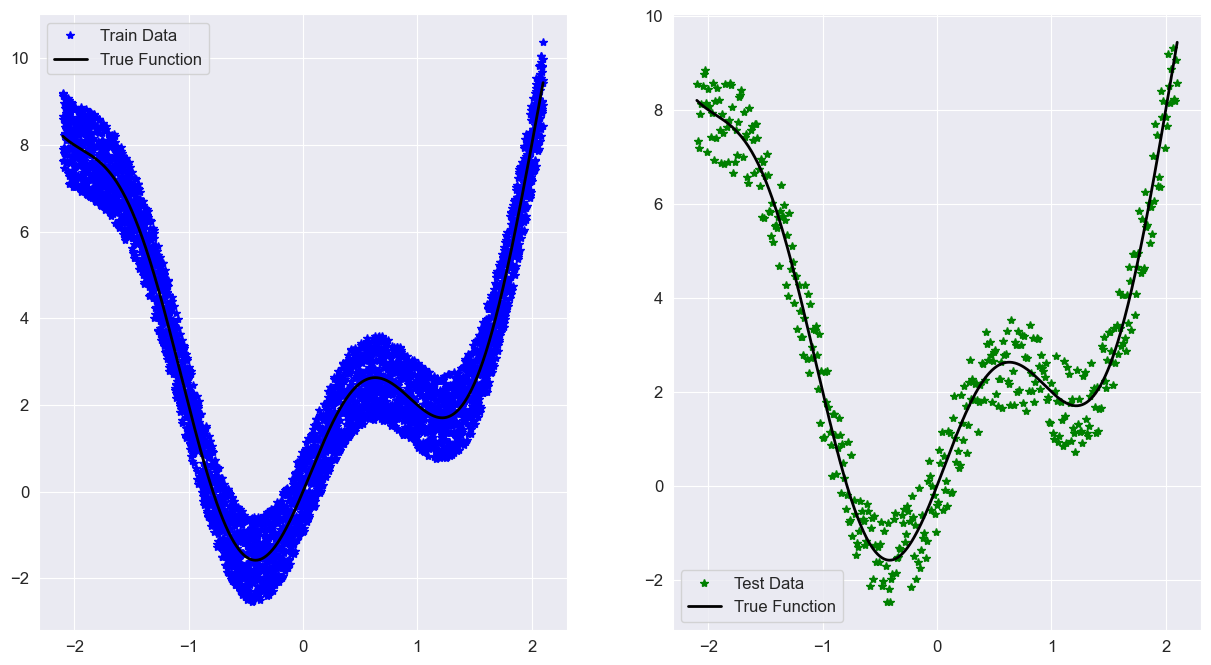

In [40]:
fig,axes = plt.subplots(1,2)
ax = axes[0]
ax.plot(X_train, y_train, 'b*', label='Train Data')
ax.plot(X_train, y_true, c ='k', linewidth =2, label='True Function')
ax.legend()

ax = axes[1]
ax.plot(X_test, y_test, 'g*', label='Test Data')
ax.plot(X_test, y_true_test, c ='k', linewidth =2, label='True Function')
ax.legend();

In [41]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))  

In [42]:
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [43]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
next(iter(train_ds))

(<tf.Tensor: shape=(64,), dtype=float64, numpy=
 array([-0.166,  0.3  ,  1.008, -0.336,  0.433,  0.86 , -1.627,  1.484,
        -1.391,  0.318, -1.007,  0.289,  0.49 , -0.58 , -0.118, -0.269,
         0.866, -1.675, -1.396,  1.758, -1.438,  0.437,  2.037, -1.596,
         0.588,  1.339,  1.243, -1.299, -1.55 , -1.946,  0.52 , -1.165,
        -0.806,  0.518,  1.115, -2.05 , -1.169, -2.012,  1.643,  1.462,
         1.335, -0.632,  0.818, -1.231, -2.004,  2.095, -0.99 ,  0.99 ,
        -0.894, -0.209, -1.184, -1.783,  0.255,  1.501, -2.041,  1.743,
         0.893, -1.988, -1.985, -2.061,  1.363, -0.296, -0.578, -0.088])>,
 <tf.Tensor: shape=(64,), dtype=float64, numpy=
 array([-1.37747328,  2.2909299 ,  1.89157305, -1.5311818 ,  1.5707243 ,
         1.75688239,  7.02455618,  2.42606145,  6.1745375 ,  2.06253532,
         2.1770797 ,  0.76570631,  2.24430999, -1.30564634, -0.43968458,
        -1.43613083,  1.42499514,  7.19929249,  6.30470927,  4.60707559,
         6.15907015,  2.26935862,

In [45]:
for features, labels in train_ds.take(1):
    print(features.shape, labels.shape)

(64,) (64,)


## Define Model 
Functinal API

In [46]:
num_features = 1
# initializer = tf.keras.initializers.HeUniform(seed=RANDOM_STATE)

input_layer = tf.keras.Input(shape=(1,))
hidden_layer = tf.keras.layers.Dense(512, activation = 'relu') (input_layer)
hidden_layer = tf.keras.layers.Dense(256, activation = 'relu') (hidden_layer)
output_layer = tf.keras.layers.Dense(1) (hidden_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
print(model)


<Functional name=functional_1, built=True>


In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
loss_fn = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanAbsoluteError()

In [48]:
model.compile(optimizer = optimizer, loss = loss_fn, metrics = [metrics])

with Batch normalization

In [49]:
#call backs:
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logDir'
)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = PATIENCE,
    verbose = 1,
    restore_best_weights =True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = LR_FACTOR,
    patience = LR_PATIENCE,
    verbose = 1,
    mode = 'auto',
    min_lr = MIN_LR,
)

In [ ]:
history = model.fit(train_ds,validation_data = test_ds,callbacks = [es_callback,lr_callback], epochs = EPOCHS)

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.3138 - mean_absolute_error: 2.3681 - val_loss: 3.8045 - val_mean_absolute_error: 1.6475 - learning_rate: 3.0000e-04
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3500 - mean_absolute_error: 1.5102 - val_loss: 2.8853 - val_mean_absolute_error: 1.4057 - learning_rate: 3.0000e-04
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5270 - mean_absolute_error: 1.2985 - val_loss: 2.1228 - val_mean_absolute_error: 1.1969 - learning_rate: 3.0000e-04
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8071 - mean_absolute_error: 1.0879 - val_loss: 1.5343 - val_mean_absolute_error: 0.9967 - learning_rate: 3.0000e-04
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3818 - mean_absolute_error: 0.9276 - val_loss: 1.3128 - val_mean_absolute_error: 0.8934 - learning_rate: 3.0000e-04
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2454 - mean_absolute_error: 0.8632 - val_loss: 1.2572 

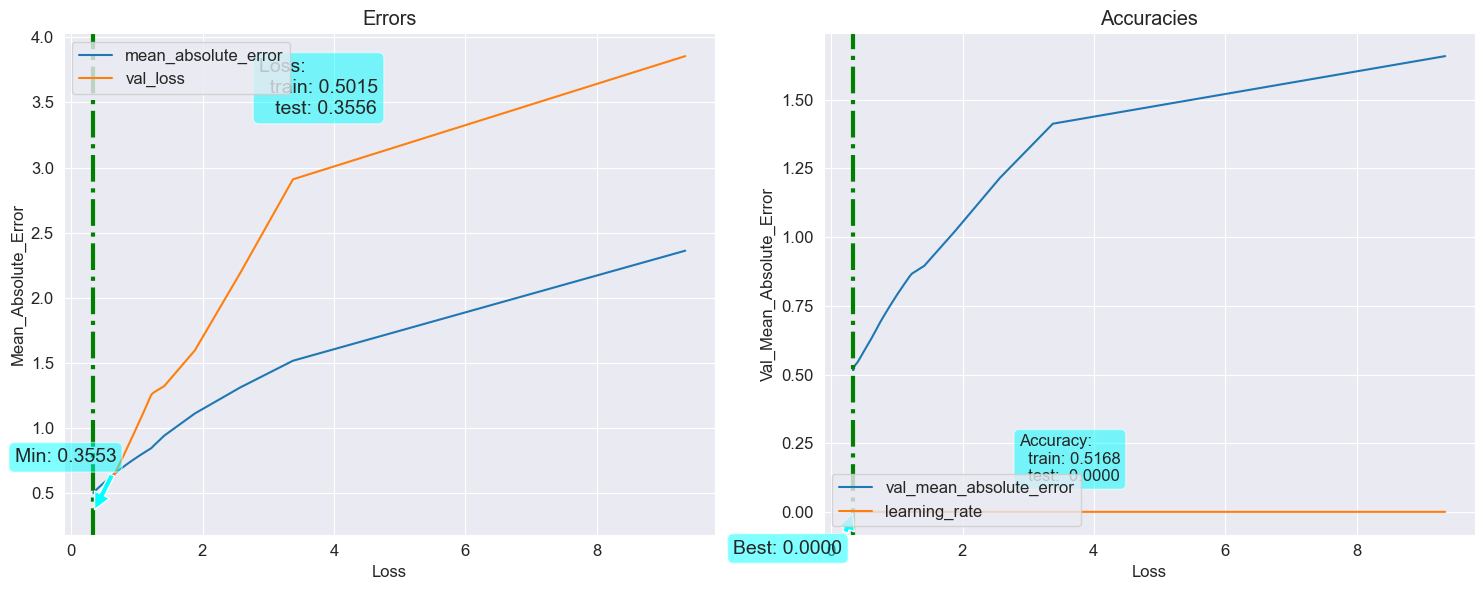

In [30]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)
# history.history

In [20]:
model.evaluate(train_ds, verbose= 2)
model.evaluate(test_ds, verbose= 2)

66/66 - 0s - 2ms/step - loss: 0.3358 - mean_absolute_error: 0.5016
7/7 - 0s - 4ms/step - loss: 0.3560 - mean_absolute_error: 0.5174


[0.35598301887512207, 0.5173875093460083]

In [ ]:
y_true, y_pred =[],[]
for feat, lbls in train_ds:
    pred = model(feat).numpy()
    y_true.extend(lbls)
    y_pred.extend(pred.argmax(axis=1))
print(f'Accuracy:{accuracy_score(y_true,y_pred)}')
print(classification_report(y_true, y_pred))